# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import torch
import torchinfo
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
from polcanet import PolcaNet
import polcanet.reports as report
import polcanet.utils as ut

Current default figure size: [3.5, 2.625]
New default figure size: [5.25, 3.9375]


In [5]:
import random
random_seed = 5
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

exp = ut.ExperimentInfoHandler(
    name="cifar10_dataset",
    description="POLCA-Net on cifar10 dataset",
    random_seed=random_seed,
)
ut.set_save_fig(True)
ut.set_save_path(str(exp.get_experiment_folder()))
print(f"Saving Images: {ut.get_save_fig()}, saving in path: {ut.get_save_path()}")

Saving Images: True, saving in path: /data1/deploy/polcanet/examples/notebooks/experiments/cifar10_dataset


### Load dataset

In [6]:
from torchvision.datasets import CIFAR10
# Load CIFAR-10 dataset
cifar_trainset = CIFAR10(root="data/CIFAR10", train=True, download=True, transform=None)
cifar_testset = CIFAR10(root="data/CIFAR10", train=False, download=True, transform=None)
cifar_trainset.data[0].shape

Files already downloaded and verified
Files already downloaded and verified


(32, 32, 3)

In [7]:
train_dataset = cifar_trainset.data / 255.0  #.reshape(-1, 32, 32, 3) / 255.0 
eval_dataset = cifar_testset.data / 255.0 # .reshape(-1, 32, 32, 3) / 255.0   

y = np.array(cifar_trainset.targets)
y_test = np.array(cifar_testset.targets)

X = np.array(train_dataset, dtype=np.float32)
X = np.squeeze(X)

X_test = np.array(eval_dataset, dtype=np.float32)
X_test = np.squeeze(X_test)

if X.ndim==4:
    X = np.moveaxis(X, -1, 1)
    X_test = np.moveaxis(X_test, -1, 1)
    

train_dataset.shape, eval_dataset.shape, X.shape, X_test.shape, y.shape, y_test.shape, X[0].min(),X[0].max()

((50000, 32, 32, 3),
 (10000, 32, 32, 3),
 (50000, 3, 32, 32),
 (10000, 3, 32, 32),
 (50000,),
 (10000,),
 np.float32(0.0),
 np.float32(1.0))

cifar10 train dataset images:


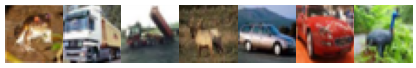

cifar10 dataset images:


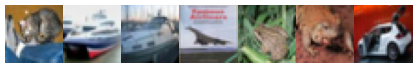

In [8]:
ut.set_fig_prefix("train")
print("cifar10 train dataset images:")
ut.plot_train_images(X, "", n=7)
ut.set_fig_prefix("test")
print("cifar10 dataset images:")
ut.plot_train_images(X_test, "", n=7)

### Fit standard sklearn PCA

In [9]:
32*3*3

288

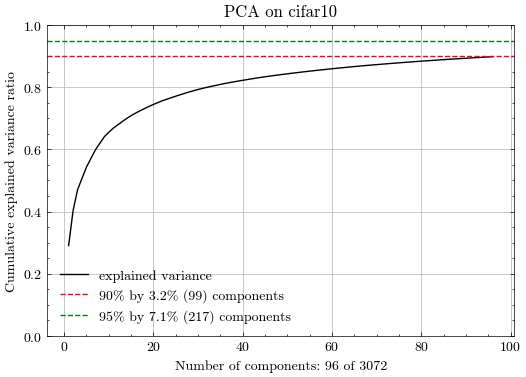

In [10]:
n_components = 32 * 3 
fig, axs = plt.subplots(1,1,sharex=True, sharey=True,layout='constrained')
pca = ut.get_pca(X,n_components=n_components,title="PCA on cifar10",ax=axs)
Xpca = pca.transform(np.squeeze(X.reshape(X.shape[0], -1)))
plt.show()

### Fit POLCANet

In [11]:
N = X[0].shape[-1]
M = X[0].shape[-2]
X[0].shape, N, M

((3, 32, 32), 32, 32)

In [12]:
act_fn = torch.nn.SiLU
input_dim = X[0].shape
latent_dim = pca.n_components
assert N == input_dim[-1], "input_dim[-1] should match first matrix dimension N"
assert M == input_dim[-2], "input_dim[-2] should match second matrix dimension M"

from polcanet.aencoders import ConvEncoder, ConvDecoder, LinearDecoder, VGG

encoder = ConvEncoder(
    input_channels=3,
    latent_dim=latent_dim,
    conv_dim=2,
    initial_channels=8,
    growth_factor=2,
    num_layers=3,
    act_fn=act_fn,
)

# encoder = VGG('VGG11', latent_dim=latent_dim, act_fn=act_fn)


# # Load a pre-trained ResNet model and modify it for CIFAR-10
# encoder = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # Load a pre-trained ResNet18 model
# num_ftrs = encoder.fc.in_features
# encoder.fc = torch.nn.Linear(num_ftrs, latent_dim)  # Modify the last layer for 10 classes of CIFAR-10



decoder = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=8*256,
    num_layers=3,
    act_fn=act_fn,
    bias=False,
)

# decoder = ConvDecoder(
#     latent_dim=latent_dim,
#     output_channels=3,
#     conv_dim=2,
#     num_layers=3,
#     initial_channels=8,
#     growth_factor=2,
#     act_fn= torch.nn.Identity, # act_fn,
#     output_act_fn= torch.nn.Identity, # torch.nn.Sigmoid,
#     final_output_size=(32, 32),
# )


model = PolcaNet(
    encoder=encoder,
    decoder=decoder,
    latent_dim=latent_dim,
    alpha=1.0,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss   
)
print(model)
summary = torchinfo.summary(
    model,
    (1,3, N, M),
    dtypes=[torch.float],
    verbose=1,
    col_width=16,
    col_names=["kernel_size", "output_size", "num_params"],
    row_settings=["var_names"],
)
ut.save_text(str(model), "model.txt")
ut.save_text(str(summary), "model_summary.txt")

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): Sequential(
      (0): ConvEncoder(
        (encoder): Sequential(
          (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): SiLU()
          (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (3): SiLU()
          (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (5): SiLU()
          (6): Flatten(start_dim=1, end_dim=-1)
          (7): Linear(in_features=512, out_features=384, bias=True)
          (8): SiLU()
          (9): Linear(in_features=384, out_features=96, bias=True)
        )
      )
      (1): Softsign()
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=96, out_features=2048, bias=False)
      (1): SiLU()
      (2): Linear(in_features=2048, out_features=2048, bias=False)
      (3): SiLU()
      (4): Linear(in_features=2048, out_features=3072, bias=False)
    )
  )
  (polca_loss): Po

In [13]:
# train_dataloader = DataLoader(X, batch_size=2*512, shuffle=True,num_workers=0)
# test_dataloader = DataLoader(X_test, batch_size=2*512, shuffle=True, num_workers=0)

In [14]:
model.to(device)
model.train_model(data=X,batch_size=2*256, num_epochs=1000, report_freq=10, lr=1e-3)

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Final metrics at epoch: 1000
Total Loss: 0.01326
Reconstruction Loss: 0.007623
Orthogonality Loss: 0.003091
Center of Mass Loss: 0.001595
Variance Reduction Loss: 0.0009523


np.float64(0.013261419530881911)

In [15]:
model.train_model(data=X,batch_size=2*256, num_epochs=1000, report_freq=10, lr=1e-4)

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Final metrics at epoch: 1000
Total Loss: 0.009596
Reconstruction Loss: 0.00642
Orthogonality Loss: 0.002463
Center of Mass Loss: 0.0004768
Variance Reduction Loss: 0.0002366


np.float64(0.009596273046443048)

In [16]:
model.train_model(data=X, batch_size=2*256, num_epochs=100, report_freq=10, lr=1e-5)

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Final metrics at epoch: 100
Total Loss: 0.009399
Reconstruction Loss: 0.006361
Orthogonality Loss: 0.002383
Center of Mass Loss: 0.0004459
Variance Reduction Loss: 0.0002087


np.float64(0.00939859981097433)

## Evaluate results

## Evaluate results

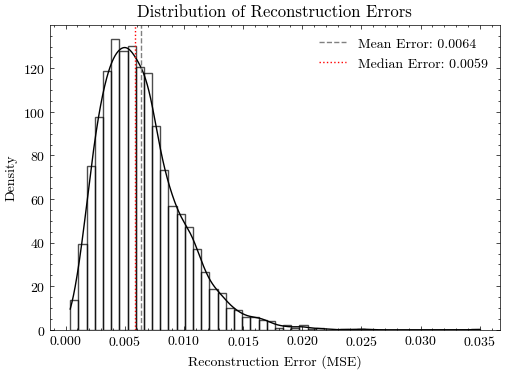

Mean Reconstruction Error: 0.0064
Median Reconstruction Error: 0.0059
Min Reconstruction Error: 0.0004
Max Reconstruction Error: 0.0350


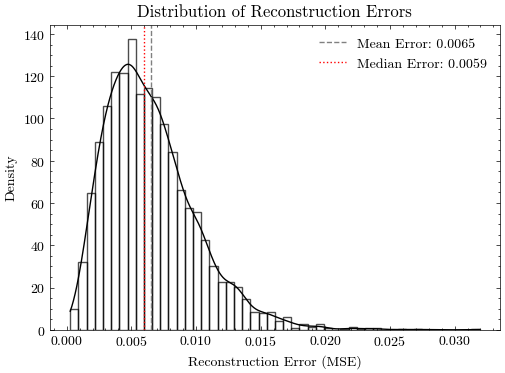

Mean Reconstruction Error: 0.0065
Median Reconstruction Error: 0.0059
Min Reconstruction Error: 0.0003
Max Reconstruction Error: 0.0319


In [17]:
ut.set_fig_prefix("train")
report.analyze_reconstruction_error(model, X[:5000])
ut.set_fig_prefix("test")
report.analyze_reconstruction_error(model, X_test[:5000])

In [18]:
latents, reconstructed = model.predict(X)

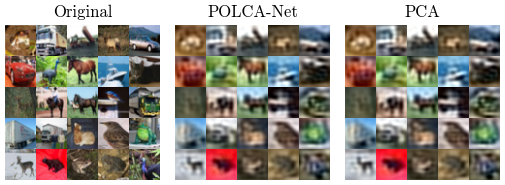

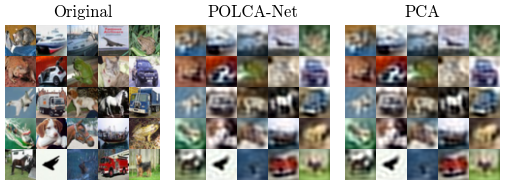

In [19]:
# Assuming images are properly defined as before
images = X[0:25]
ut.set_fig_prefix("train")
ut.plot_reconstruction_comparison(model,pca,images,n_components=pca.n_components,nrow=5)
images = X_test[0:25]
ut.set_fig_prefix("test")
ut.plot_reconstruction_comparison(model,pca,images,n_components=pca.n_components,nrow=5)


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: 0.0001
    - Max cosine similarity: 0.1302
    - Min cosine similarity: -0.1058
    


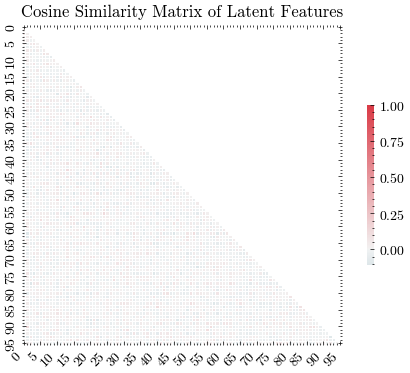

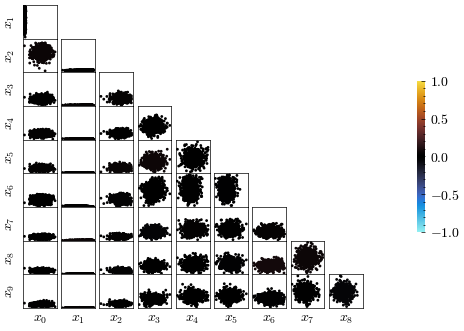


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: -0.0001
    - Max cosine similarity: 0.1212
    - Min cosine similarity: -0.1565
    


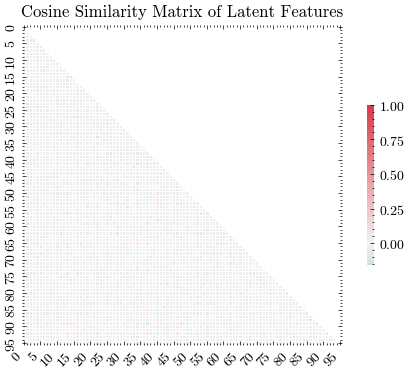

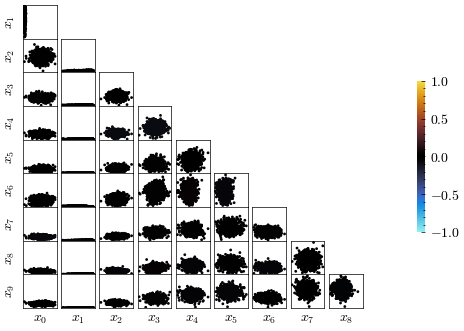

In [20]:
ut.set_fig_prefix("train")
report.orthogonality_test_analysis(model, X)
ut.set_fig_prefix("test")
report.orthogonality_test_analysis(model, X_test)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 2.0563
    - Variance fit to exponential distribution (sum of squared differences):
     0.9695
    


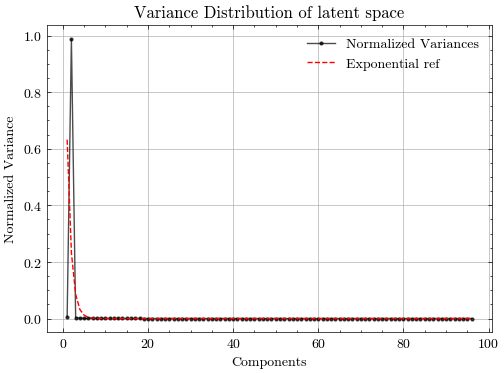

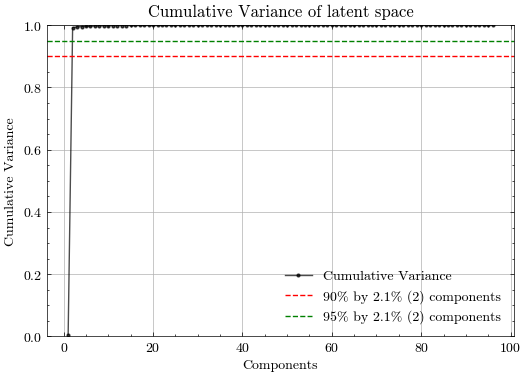

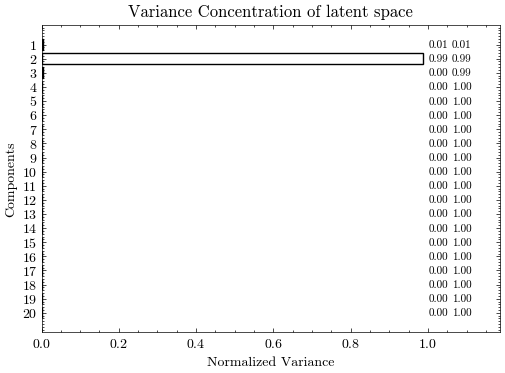


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 2.0586
    - Variance fit to exponential distribution (sum of squared differences):
     0.9666
    


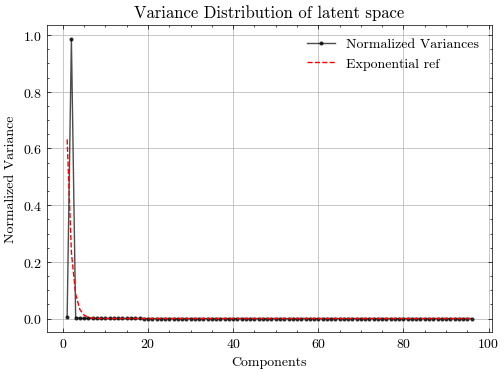

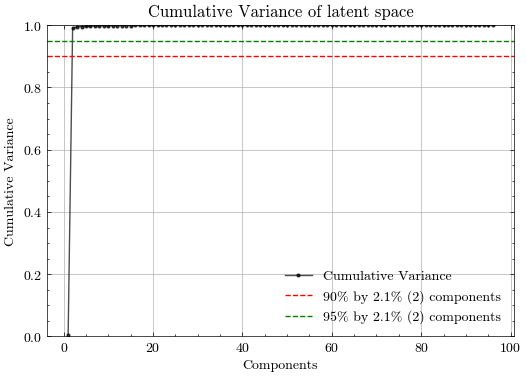

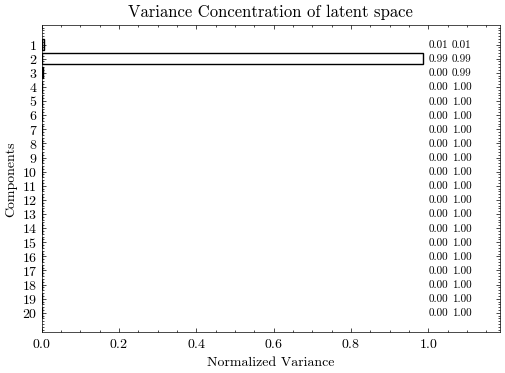

In [21]:
ut.set_fig_prefix("train")
report.variance_test_analysis(model, X)
ut.set_fig_prefix("test")
report.variance_test_analysis(model, X_test)

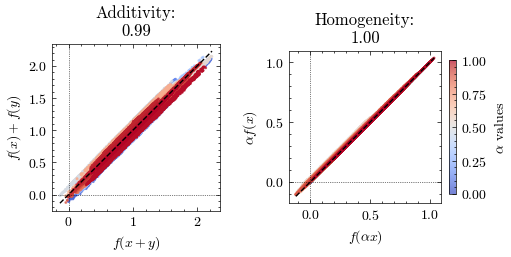

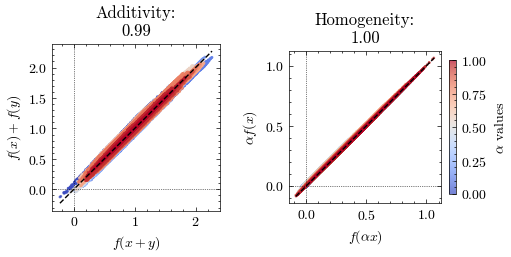

In [22]:
ut.set_fig_prefix("train")
report.linearity_tests_analysis(model, X,     alpha_min=0,num_samples=100)
ut.set_fig_prefix("test")
report.linearity_tests_analysis(model, X_test,alpha_min=0,num_samples=100)

## Test Classification with two components on PCA vs POLCA Net

In [23]:
_ = ut.make_classification_report(model, pca, X_test, y_test,n_components=pca.n_components)

output shape from pca (7000, 96) (3000, 96)
output shape from POLCA (7000, 96) (3000, 96)


/data1/conda/envs/python3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Performance Metrics DataFrame:


/data1/conda/envs/python3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data1/conda/envs/python3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data1/conda/envs/python3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Accuracy       Error rate        Matthews       F1-Score  \
Transformation            PCA POLCA        PCA  POLCA      PCA POLCA      PCA   
Classifier                                                                      
Gaussian Naive Bayes     0.28  0.31      71.73  68.87     0.21  0.24     0.26   
Linear SVM               0.30  0.33      69.60  67.13     0.24  0.26     0.28   
Logistic Regression      0.31  0.33      68.73  67.20     0.25  0.26     0.29   
Perceptron               0.26  0.20      73.97  79.83     0.19  0.15     0.19   
Ridge Classifier         0.31  0.33      69.23  67.13     0.25  0.26     0.28   

                            
Transformation       POLCA  
Classifier                  
Gaussian Naive Bayes  0.30  
Linear SVM            0.33  
Logistic Regression   0.33  
Perceptron            0.17  
Ridge Classifier      0.32


Wilcoxon Signed-Rank Test Results DataFrame:


,Wilcoxon Test,P-Value,Significant (p < 0.05)
Accuracy,5.0,0.625,No better method
Error rate,5.0,0.625,No better method
Matthews,5.0,0.625,No better method
F1-Score,1.0,0.125,No better method


In [24]:
experiment_data = {
    "cifar10" : (X_test,model,pca),   
}
df_image_metrics = ut.image_metrics_table(experiment_data, n_components=pca.n_components)

,NMSE,PSNR,SSI
Method,,,
POLCA cifar10,0.0265,22.5731,0.7430
PCA cifar10,0.0262,22.6187,0.7446
